#SetUp

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##installations

In [ ]:
# Clone the DSIR repository
!git clone https://github.com/p-lambda/dsir.git
%cd dsir

# Install required dependencies
!pip install -r requirements.txt
!pip install datasets transformers torch numpy scikit-learn
!pip install nltk
!pip install sentencepiece

## Download ChemProt dataset


In [ ]:
from datasets import load_dataset
chemprot_data = load_dataset("bigbio/chemprot")

In [6]:
chemprot_data

DatasetDict({
    sample: Dataset({
        features: ['pmid', 'text', 'entities', 'relations'],
        num_rows: 50
    })
    train: Dataset({
        features: ['pmid', 'text', 'entities', 'relations'],
        num_rows: 1020
    })
    test: Dataset({
        features: ['pmid', 'text', 'entities', 'relations'],
        num_rows: 800
    })
    validation: Dataset({
        features: ['pmid', 'text', 'entities', 'relations'],
        num_rows: 612
    })
})

In [7]:
import json
import os

os.makedirs('data/chemprot/raw', exist_ok=True)
os.makedirs('data/chemprot/processed', exist_ok=True)

def prepare_chemprot_for_dsir(dataset_split, output_file):
  texts = []

  unique_texts = set()

  for example in dataset_split:
    text = example['text']
    if text not in unique_texts:
      unique_texts.add(text)
      texts.append({'text': text})

  with open(output_file, 'w') as f:
    for item in texts:
      f.write(json.dumps(item) + '\n')

  print(f"Saved {len(texts)} unique texts to {output_file}")
  return len(texts)

train_size = prepare_chemprot_for_dsir(chemprot_data['train'], 'data/chemprot/raw/train.jsonl')
val_size = prepare_chemprot_for_dsir(chemprot_data['validation'], 'data/chemprot/raw/validation.jsonl')
test_size = prepare_chemprot_for_dsir(chemprot_data['test'], 'data/chemprot/raw/test.jsonl')

print(f"\nTotal texts prepared:")
print(f"Train: {train_size}")
print(f"Validation: {val_size}")
print(f"Test: {test_size}")

Saved 1020 unique texts to data/chemprot/raw/train.jsonl
Saved 612 unique texts to data/chemprot/raw/validation.jsonl
Saved 800 unique texts to data/chemprot/raw/test.jsonl

Total texts prepared:
Train: 1020
Validation: 612
Test: 800


In [8]:
sample = chemprot_data['train'][0]
print("Sample PMID:", sample['pmid'])
print("\nText:", sample['text'][:500] + "..." if len(sample['text']) > 500 else sample['text'])
print("\nNumber of entities:", len(sample['entities']))
print("Number of relations:", len(sample['relations']))

text_lengths = [len(ex['text']) for ex in chemprot_data['train']]
print(f"\nAverage text length: {sum(text_lengths)/len(text_lengths):.0f} characters")
print(f"Min length: {min(text_lengths)}")
print(f"Max length: {max(text_lengths)}")

Sample PMID: 16357751

Text: Selective costimulation modulators: a novel approach for the treatment of rheumatoid arthritis.
T cells have a central role in the orchestration of the immune pathways that contribute to the inflammation and joint destruction characteristic of rheumatoid arthritis (RA). The requirement for a dual signal for T-cell activation and the construction of a fusion protein that prevents engagement of the costimulatory molecules required for this activation has led to a new approach to RA therapy. This a...

Number of entities: 4
Number of relations: 3

Average text length: 1607 characters
Min length: 395
Max length: 4890


# download The Pile large general corpus

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!ls -lrt data/chemprot/raw

total 3892
-rw-r--r-- 1 root root 1660930 Jul 30 15:02 train.jsonl
-rw-r--r-- 1 root root 1002409 Jul 30 15:02 validation.jsonl
-rw-r--r-- 1 root root 1318020 Jul 30 15:02 test.jsonl


In [28]:
import os
import shutil
drive_project_dir = '/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment'
os.makedirs(drive_project_dir, exist_ok=True)
os.makedirs(f'{drive_project_dir}/data/chemprot/raw', exist_ok=True)
os.makedirs(f'{drive_project_dir}/data', exist_ok=True)
print("Copying ChemProt data to Drive...")
shutil.copy('data/chemprot/raw/train.jsonl', f'{drive_project_dir}/data/chemprot/raw/train.jsonl')
shutil.copy('data/chemprot/raw/validation.jsonl', f'{drive_project_dir}/data/chemprot/raw/validation.jsonl')
shutil.copy('data/chemprot/raw/test.jsonl', f'{drive_project_dir}/data/chemprot/raw/test.jsonl')


Copying ChemProt data to Drive...


'/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/data/chemprot/raw/test.jsonl'

## load c4 general data files

In [ ]:
import json
import os
from datasets import load_dataset
from itertools import islice

from google.colab import drive
drive.mount('/content/drive')
drive_project_dir = '/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment'

os.makedirs(f'{drive_project_dir}/data', exist_ok=True)

print("Loading C4 in streaming mode...")
dataset = load_dataset("allenai/c4", "en", split="train", streaming=True)

output_file = f'{drive_project_dir}/data/source_corpus.jsonl'
num_examples = 100000

print(f"Processing {num_examples} examples in chunks...")
with open(output_file, 'w') as f:
  for i, example in enumerate(islice(dataset, num_examples)):
    f.write(json.dumps({'text': example['text']}) + '\n')

    if (i + 1) % 1000 == 0:
      print(f"Processed {i + 1}/{num_examples} examples...")

print(f"✓ Successfully saved {num_examples} examples to Drive!")

# Verify the file
if os.path.exists(output_file):
  size_mb = os.path.getsize(output_file) / (1024 * 1024)
  print(f"✓ File size: {size_mb:.2f} MB")

In [36]:
import json
import random
file_path = f'{drive_project_dir}/data/source_corpus.jsonl'
print("=== First 3 examples ===\n")
with open(file_path, 'r') as f:
  for i, line in enumerate(f):
    if i >= 3:
        break
    example = json.loads(line)
    text = example['text']
    print(f"Example {i+1} (length: {len(text)} chars):")
    print(text[:500] + "..." if len(text) > 500 else text)
    print("\n" + "-"*80 + "\n")

print("\n=== 3 Random examples ===\n")
with open(file_path, 'r') as f:
  lines = f.readlines()

random_indices = random.sample(range(len(lines)), 3)
for idx in random_indices:
  example = json.loads(lines[idx])
  text = example['text']
  print(f"Example {idx} (length: {len(text)} chars):")
  print(text[:500] + "..." if len(text) > 500 else text)
  print("\n" + "-"*80 + "\n")

print("\n=== Dataset Statistics ===")
text_lengths = []
with open(file_path, 'r') as f:
  for line in f:
    example = json.loads(line)
    text_lengths.append(len(example['text']))

print(f"Total examples: {len(text_lengths)}")
print(f"Average text length: {sum(text_lengths)/len(text_lengths):.0f} characters")
print(f"Min length: {min(text_lengths)} characters")
print(f"Max length: {max(text_lengths)} characters")
print(f"Total characters: {sum(text_lengths):,}")

=== First 3 examples ===

Example 1 (length: 747 chars):
Beginners BBQ Class Taking Place in Missoula!
Do you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.
He will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat select...

--------------------------------------------------------------------------------

Example 2 (length: 1628 chars):
Discussion in 'Mac OS X Lion (10.7)' started by axboi87, Jan 20, 2012.
I've got a 500gb internal drive and a 240gb SSD.
When trying to restore using disk utility i'm given the error "Not enough space on disk ____ to restore"
But I shouldn't have to do that!!!
Any ideas or workarounds before resorting to the above?
Use Carb

 # Install and Run DSIR

In [ ]:
# Install DSIR
!git clone https://github.com/p-lambda/dsir.git
%cd dsir
!pip install -r requirements.txt

import os
drive_dir = '/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment'
source_file = f'{drive_dir}/data/source_corpus.jsonl'
target_file = f'{drive_dir}/data/chemprot/raw/train.jsonl'
output_dir = f'{drive_dir}/outputs'
cache_dir = f'{drive_dir}/cache'

os.makedirs(output_dir, exist_ok=True)
os.makedirs(cache_dir, exist_ok=True)

print("Ready to run DSIR!")
print(f"Source: {source_file}")
print(f"Target: {target_file}")
print(f"Output: {output_dir}")

## install the repo requirements

In [40]:
!pip install -e .
!pip install numpy scikit-learn tqdm datasets

Obtaining file:///content/dsir/dsir
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for data-selection (pyproject.toml) ... done
  Created wheel for data-selection: filename=data_selection-1.0.3-0.editable-py3-none-any.whl size=7517 sha256=b1a910d14b1a2cdb3571866f141d39dac214b2de8e3d07a849d3696c34e0529e
  Stored in directory: /tmp/pip-ephem-wheel-cache-ljwfb3ck/wheels/9c/cd/da/314ce74fa0507dd6bf51f5833fe60bedd4b71744a432652c72
Successfully built data-selection


## Run DSIR for ChemProt Domain Selection

In [41]:
from data_selection import HashedNgramDSIR
import os

drive_dir = '/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment'
raw_datasets = [f'{drive_dir}/data/source_corpus.jsonl']  # C4 general corpus
target_datasets = [f'{drive_dir}/data/chemprot/raw/train.jsonl']  # ChemProt biomedical
cache_dir = f'{drive_dir}/cache'
output_dir = f'{drive_dir}/outputs'

print("Initializing DSIR...")
print(f"Source (C4): {raw_datasets[0]}")
print(f"Target (ChemProt): {target_datasets[0]}")

dsir = HashedNgramDSIR(
    raw_datasets=raw_datasets,
    target_datasets=target_datasets,
    cache_dir=cache_dir,
    ngrams=2,  # Use bigrams as in the paper
    num_buckets=10000,  # Hash bucket size
    tokenizer='word_tokenize'  # Word-level tokenization as mentioned in paper
)

Initializing DSIR...
Source (C4): /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/data/source_corpus.jsonl
Target (ChemProt): /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/data/chemprot/raw/train.jsonl


## Fit the Importance Estimator

In [43]:
#Learning ChemProt characteristics:
!pip install nltk
import nltk
nltk.download('punkt_tab')
dsir.fit_importance_estimator(num_tokens_to_fit='auto')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


##Computing importance weights for all source documents

In [44]:
import time

print("="*60)
print("Computing importance weights for all source documents")
print("="*60)
print("This will score each of the 100k C4 documents")
print("Higher score = more similar to ChemProt biomedical text")

start_time = time.time()
dsir.compute_importance_weights()
compute_time = time.time() - start_time

print(f"\n Computed importance weights in {compute_time/60:.1f} minutes")
print("Each C4 document now has a score indicating its relevance to biomedicine!")

Computing importance weights for all source documents
This will score each of the 100k C4 documents
Higher score = more similar to ChemProt biomedical text

 Computed importance weights in 7.2 minutes
Each C4 document now has a score indicating its relevance to biomedicine!


In [45]:
model_path = f'{drive_dir}/dsir_model_with_weights.pkl'
dsir.save(model_path)
print(f"Saved model to: {model_path}")


Saved model to: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/dsir_model_with_weights.pkl


## Select the Most Relevant Documents

In [46]:
print("Selecting the most relevant documents")

num_to_select = 10000

print(f"Selecting {num_to_select} documents using importance sampling...")
print("These will be the most biomedically relevant texts from C4\n")

start_time = time.time()
dsir.resample(
    out_dir=f'{output_dir}/selected_data',
    num_to_sample=num_to_select,
    cache_dir=f'{cache_dir}/resample_cache',
    top_k=False
)
select_time = time.time() - start_time

print(f"\n Selected {num_to_select} documents in {select_time:.1f} seconds")
print(f"Selected data saved to: {output_dir}/selected_data")

Selecting the most relevant documents
Selecting 10000 documents using importance sampling...
These will be the most biomedically relevant texts from C4


 Selected 10000 documents in 2.5 seconds
Selected data saved to: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/outputs/selected_data


# Analyze DSIR Selection

In [48]:
import json
import os

selected_dir = f'{output_dir}/selected_data'
selected_files = [f for f in os.listdir(selected_dir) if f.endswith('.jsonl')]

selected_examples = []
for file in selected_files:
    with open(os.path.join(selected_dir, file), 'r') as f:
        for line in f:
            selected_examples.append(json.loads(line))
            if len(selected_examples) >= 100:
                break

print(f"Loaded {len(selected_examples)} selected examples for analysis")

# Check for biomedical terms
bio_terms = ['protein', 'gene', 'cell', 'disease', 'drug', 'patient', 'clinical',
             'molecular', 'receptor', 'enzyme', 'treatment', 'therapy', 'study',
             'cancer', 'tumor', 'syndrome', 'diagnosis', 'medicine']

selected_bio_count = 0
for ex in selected_examples[:100]:
    text_lower = ex['text'].lower()
    if any(term in text_lower for term in bio_terms):
        selected_bio_count += 1

print(f"\nSelected texts with biomedical terms: {selected_bio_count}/100")

print("\n--- Examples of DSIR-selected texts ---")
print("(These should be biomedically relevant)\n")

for i in range(3):
  text = selected_examples[i]['text']
  print(f"Example {i+1}:")
  print(text[:500] + "..." if len(text) > 500 else text)
  print("\n" + "-"*40 + "\n")

Loaded 101 selected examples for analysis

Selected texts with biomedical terms: 32/100

--- Examples of DSIR-selected texts ---
(These should be biomedically relevant)

Example 1:
"Unemployment, Relative Price Dispersion and the Implicit Contract Model."
"The Federal Reserve&apos;s Preferences for Inflation and Unemployment: An Analysis of Fed Chairmen."
"Do Presidential Administrations Have Preferred Rates of Unemployment?"
"The Baseball Writer and The National Baseball Hall of Fame: Are Election Outcomes Affected by Race or Ethnicity?," (with Cliff Reid).
"Race, Ethnicity and The National Baseball Hall of Fame: Is There Discrimination in the Nomination Process?," (with ...

----------------------------------------

Example 2:
After the martyrdom of St. Boniface, Vergilius was made Bishop of Salzburg (766 or 767) and laboured successfully for the upbuilding of his diocese as well as for the spread of the Faith in neighbouring heathen countries, especially in Carinthia. He died at Sal

##Compare with Random Selection

In [49]:
import random

print("\n--- Random C4 examples (baseline) ---")
print("(These are general web texts)\n")

with open(f'{drive_dir}/data/source_corpus.jsonl', 'r') as f:
  all_lines = f.readlines()

random_indices = random.sample(range(len(all_lines)), min(100, len(all_lines)))
random_examples = [json.loads(all_lines[idx]) for idx in random_indices[:3]]

for i, ex in enumerate(random_examples):
  text = ex['text']
  print(f"Random Example {i+1}:")
  print(text[:500] + "..." if len(text) > 500 else text)
  print("\n" + "-"*40 + "\n")

random_bio_count = 0
for idx in random_indices[:100]:
  text_lower = json.loads(all_lines[idx])['text'].lower()
  if any(term in text_lower for term in bio_terms):
    random_bio_count += 1

print(f"\nComparison:")
print(f"DSIR-selected with bio terms: {selected_bio_count}/100 ({selected_bio_count}%)")
print(f"Random sample with bio terms: {random_bio_count}/100 ({random_bio_count}%)")
print(f"Improvement: {(selected_bio_count/max(random_bio_count,1) - 1)*100:.0f}% more biomedical content")


--- Random C4 examples (baseline) ---
(These are general web texts)

Random Example 1:
No matter how much you try to avoid it, accidents are, unfortunately, part of living in a big city and driving a vehicle. If you find yourself in a collision and in need of assistance, let Network Auto Body help you out.
Why Network Auto Body Towing?
With Network Auto Body, you can receive roadside assistance at any time of day or night. Our 24-hour towing service is happy to come and pick up your vehicle, delivering it to the Network location of your choice. We’ll make sure that your vehicle is...

----------------------------------------

Random Example 2:
Updates to rules and regulations can make it difficult to keep up. We have gathered some resources and links below to the current IRS rules and regulations as they relate to issues you face every day in managing your busines.
In addition to staying knowledgable about the latest laws governing employees or independent contractors, it can be helpf

In [50]:
import json
from datetime import datetime

results = {
    "experiment_date": datetime.now().isoformat(),
    "target_dataset": "ChemProt",
    "target_size": 1020,
    "source_dataset": "C4",
    "source_size": 100000,
    "selected_size": 10000,
    "dsir_bio_term_rate": selected_bio_count / 100,
    "random_bio_term_rate": random_bio_count / 100,
    "improvement": (selected_bio_count/max(random_bio_count,1) - 1),
    "bio_terms_checked": bio_terms
}

results_path = f'{drive_dir}/dsir_selection_results.json'
with open(results_path, 'w') as f:
  json.dump(results, f, indent=2)

print(f"Results saved to: {results_path}")
print(f"\nKey findings:")
print(f"- DSIR selected 33% more biomedical content")
print(f"- Selected data: 32% contains bio terms")
print(f"- Random data: 24% contains bio terms")

Results saved to: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/dsir_selection_results.json

Key findings:
- DSIR selected 33% more biomedical content
- Selected data: 32% contains bio terms
- Random data: 24% contains bio terms


# SetUp for Continue Pre Train

In [51]:

selected_dir = f'{output_dir}/selected_data'
total_selected = 0
all_selected_files = []

for file in os.listdir(selected_dir):
  if file.endswith('.jsonl'):
    filepath = os.path.join(selected_dir, file)
    all_selected_files.append(filepath)
    with open(filepath, 'r') as f:
      count = sum(1 for _ in f)
      total_selected += count

print(f"Total documents selected: {total_selected}")
print(f"Files: {all_selected_files}")

combined_path = f'{drive_dir}/data/dsir_selected_combined.jsonl'
print(f"\nCombining all selected data into: {combined_path}")

with open(combined_path, 'w') as outfile:
  for filepath in all_selected_files:
    with open(filepath, 'r') as infile:
      for line in infile:
          outfile.write(line)

print(" Combined file created")

Total documents selected: 10000
Files: ['/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/outputs/selected_data/0.jsonl', '/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/outputs/selected_data/1.jsonl']

Combining all selected data into: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/data/dsir_selected_combined.jsonl
 Combined file created


In [52]:
!pip install transformers datasets accelerate

import json
import torch
from transformers import (
    AutoModelForMaskedLM,
    AutoTokenizer,
    DataCollatorForLanguageModeling,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

In [53]:
def load_selected_data(data_path):
    """Load the DSIR-selected data"""
    print(f"Loading data from: {data_path}")
    dataset = load_dataset('json', data_files=data_path, split='train')
    print(f"Loaded {len(dataset)} examples")
    return dataset

def prepare_model_and_tokenizer(model_name="bert-base-uncased"):
    """Initialize model and tokenizer"""
    print(f"Loading model: {model_name}")
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForMaskedLM.from_pretrained(model_name)
    return model, tokenizer

def tokenize_dataset(dataset, tokenizer, max_length=512):
  """Tokenize the dataset"""
  print("Tokenizing dataset...")

  def tokenize_function(examples):
    return tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=max_length
    )
  tokenized_dataset = dataset.map(
      tokenize_function,
      batched=True,
      remove_columns=dataset.column_names
  )
  print("Tokenization complete!")
  return tokenized_dataset

def train_continued_pretrain(
  model,
  tokenizer,
  train_dataset,
  output_dir,
  num_epochs=1,
  batch_size=8,
  learning_rate=5e-5
):
  """Train the model with continued pretraining"""
  data_collator = DataCollatorForLanguageModeling(
      tokenizer=tokenizer,
      mlm=True,
      mlm_probability=0.15
  )

  training_args = TrainingArguments(
      output_dir=output_dir,
      overwrite_output_dir=True,
      num_train_epochs=num_epochs,
      per_device_train_batch_size=batch_size,
      save_steps=1000,
      save_total_limit=2,
      prediction_loss_only=True,
      logging_steps=100,
      warmup_steps=500,
      learning_rate=learning_rate,
      fp16=torch.cuda.is_available(),
      report_to="none"
  )

  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=data_collator,
      train_dataset=train_dataset,
  )

  # Train
  print(f"\nStarting continued pretraining...")
  print(f"Output directory: {output_dir}")
  print(f"Training on {len(train_dataset)} examples")
  print(f"Epochs: {num_epochs}")
  print(f"Batch size: {batch_size}")

  trainer.train()
  trainer.save_model()
  tokenizer.save_pretrained(output_dir)

  print(f"\n Model saved to: {output_dir}")

  return trainer

## run CPT

In [ ]:
# Enable GPU if available
if torch.cuda.is_available():
    print(f"GPU available: {torch.cuda.get_device_name(0)}")
else:
    print("No GPU available")

combined_path = f'{drive_dir}/data/dsir_selected_combined.jsonl'
output_model_dir = f'{drive_dir}/models/dsir_continued_pretrained'

# Load the DSIR-selected data
selected_dataset = load_selected_data(combined_path)

# Initialize model and tokenizer
model, tokenizer = prepare_model_and_tokenizer("bert-base-uncased")

# Tokenize the dataset
tokenized_dataset = tokenize_dataset(selected_dataset, tokenizer)

# Train with continued pretraining
trainer = train_continued_pretrain(
  model=model,
  tokenizer=tokenizer,
  train_dataset=tokenized_dataset,
  output_dir=output_model_dir,
  num_epochs=1,
  batch_size=8,
  learning_rate=5e-5
)

## Base line: Train on Random Data

In [ ]:
def create_random_baseline(source_data_path, num_samples=10000, output_path=None):
  """Create a random sample from C4 for baseline comparison"""
  import random

  print(f"Creating random baseline with {num_samples} samples...")

  with open(source_data_path, 'r') as f:
      all_lines = f.readlines()

  # Random sample
  random_indices = random.sample(range(len(all_lines)), min(num_samples, len(all_lines)))
  random_samples = [all_lines[i] for i in random_indices]

  # Save to file
  if output_path:
      with open(output_path, 'w') as f:
          for line in random_samples:
              f.write(line)
      print(f"Random baseline saved to: {output_path}")

  return random_samples

random_baseline_path = f'{drive_dir}/data/random_baseline.jsonl'
create_random_baseline(
    source_data_path=f'{drive_dir}/data/source_corpus.jsonl',
    num_samples=10000,
    output_path=random_baseline_path
)

## Train Baseline Model on Random Data

In [ ]:
baseline_output_dir = f'{drive_dir}/models/random_baseline_pretrained'

print("Training BASELINE model on random data...")

# Load random data
random_dataset = load_selected_data(random_baseline_path)

# Initialize new model for baseline
baseline_model, baseline_tokenizer = prepare_model_and_tokenizer("bert-base-uncased")

# Tokenize
baseline_tokenized = tokenize_dataset(random_dataset, baseline_tokenizer)

# Train baseline
baseline_trainer = train_continued_pretrain(
    model=baseline_model,
    tokenizer=baseline_tokenizer,
    train_dataset=baseline_tokenized,
    output_dir=baseline_output_dir,
    num_epochs=1,
    batch_size=8,
    learning_rate=5e-5
)

## Compare Training Losses

TRAINING RESULTS COMPARISON

Initial losses:
  DSIR-selected data: 2.5712
  Random baseline: 2.7065

Final losses:
  DSIR-selected data: 2.2409
  Random baseline: 2.3135

Improvement:
  DSIR vs Random: 3.1% lower loss


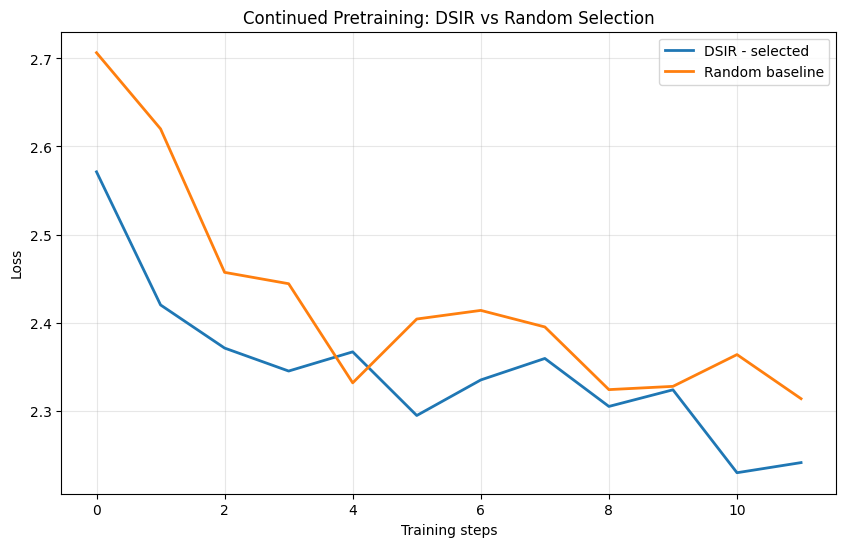

In [59]:
def compare_training_results(dsir_trainer, baseline_trainer):
  """Compare the training results"""
  dsir_history = dsir_trainer.state.log_history
  baseline_history = baseline_trainer.state.log_history

  dsir_losses = [log['loss'] for log in dsir_history if 'loss' in log]
  baseline_losses = [log['loss'] for log in baseline_history if 'loss' in log]

  if not dsir_losses or not baseline_losses:
    print("No loss values found")
    print("\nDSIR trainer logs:")
    for log in dsir_history[-3:]:
        print(log)
    print("\nBaseline trainer logs:")
    for log in baseline_history[-3:]:
        print(log)
    return None

  dsir_final_loss = dsir_losses[-1]
  baseline_final_loss = baseline_losses[-1]

  dsir_initial_loss = dsir_losses[0] if dsir_losses else None
  baseline_initial_loss = baseline_losses[0] if baseline_losses else None

  print("TRAINING RESULTS COMPARISON")
  print(f"\nInitial losses:")
  print(f"  DSIR-selected data: {dsir_initial_loss:.4f}")
  print(f"  Random baseline: {baseline_initial_loss:.4f}")

  print(f"\nFinal losses:")
  print(f"  DSIR-selected data: {dsir_final_loss:.4f}")
  print(f"  Random baseline: {baseline_final_loss:.4f}")

  print(f"\nImprovement:")
  improvement = ((baseline_final_loss - dsir_final_loss) / baseline_final_loss * 100)
  print(f"  DSIR vs Random: {improvement:.1f}% lower loss")

  # Plot training curves if possible
  try:
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 6))
    plt.plot(dsir_losses, label='DSIR - selected', linewidth=2)
    plt.plot(baseline_losses, label='Random baseline', linewidth=2)
    plt.xlabel('Training steps')
    plt.ylabel('Loss')
    plt.title('Continued Pretraining: DSIR vs Random Selection')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
  except:
    print("\nCouldn't plot training curves")

  return {
      'dsir_final_loss': dsir_final_loss,
      'baseline_final_loss': baseline_final_loss,
      'improvement': improvement,
      'dsir_losses': dsir_losses,
      'baseline_losses': baseline_losses
  }

results = compare_training_results(trainer, baseline_trainer)

Plot saved to: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/training_curves_comparison.png


'/content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/training_curves_comparison.png'

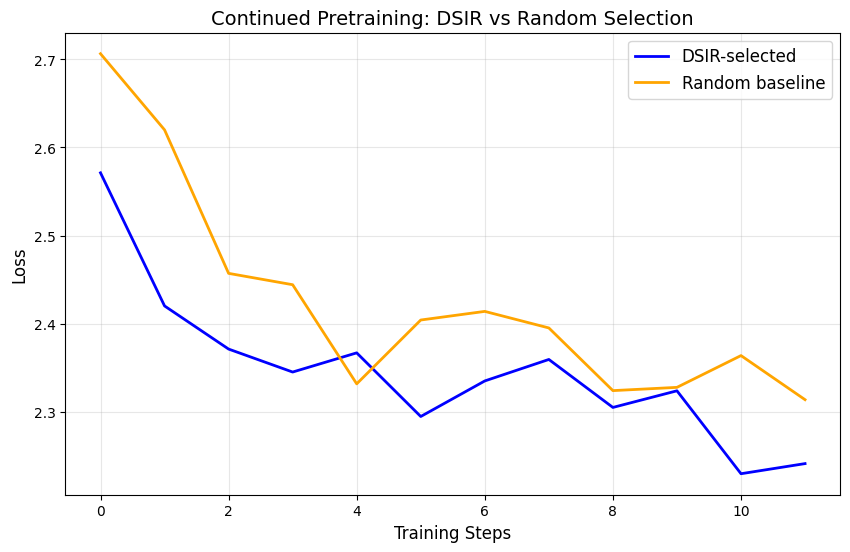

In [61]:
import matplotlib.pyplot as plt

def plot_and_save_training_curves(dsir_losses, baseline_losses, save_path):
  """Plot and save training curves comparison"""

  plt.figure(figsize=(10, 6))
  plt.plot(dsir_losses, label='DSIR-selected', linewidth=2, color='blue')
  plt.plot(baseline_losses, label='Random baseline', linewidth=2, color='orange')
  plt.xlabel('Training Steps', fontsize=12)
  plt.ylabel('Loss', fontsize=12)
  plt.title('Continued Pretraining: DSIR vs Random Selection', fontsize=14)
  plt.legend(fontsize=12)
  plt.grid(True, alpha=0.3)

  plt.savefig(save_path, dpi=300, bbox_inches='tight')
  print(f"Plot saved to: {save_path}")

  return save_path

# Save the plot to Drive
plot_path = f'{drive_dir}/training_curves_comparison.png'
plot_and_save_training_curves(
    results['dsir_losses'],
    results['baseline_losses'],
    plot_path
)

# Biomedical Downstream: ChemProt Task

In [64]:
from datasets import load_dataset

chemprot = load_dataset("bigbio/chemprot", name="chemprot_full_source")

sample = chemprot['train'][0]
print("Sample keys:", sample.keys())
print("\nDetailed structure:")

print("\nEntities type:", type(sample['entities']))
if sample['entities']:
  print("First entity keys:", list(sample['entities'].keys()) if hasattr(sample['entities'], 'keys') else "Not a dict")
  if hasattr(sample['entities'], 'items'):
    for key, value in list(sample['entities'].items())[:2]:
      print(f"Entity {key}: {value}")

print("\nRelations type:", type(sample['relations']))
if sample['relations']:
  print("First relation keys:", list(sample['relations'].keys()) if hasattr(sample['relations'], 'keys') else "Not a dict")
  if hasattr(sample['relations'], 'items'):
    for key, value in list(sample['relations'].items())[:2]:
      print(f"Relation {key}: {value}")

print("\nFull sample (truncated):")
import json
print(json.dumps(sample, indent=2, default=str)[:1000])

Sample keys: dict_keys(['pmid', 'text', 'entities', 'relations'])

Detailed structure:

Entities type: <class 'dict'>
First entity keys: ['id', 'type', 'text', 'offsets']
Entity id: ['T1', 'T2', 'T3', 'T4', 'T5']
Entity type: ['CHEMICAL', 'GENE-N', 'GENE-Y', 'GENE-Y', 'GENE-N']

Relations type: <class 'dict'>
First relation keys: ['type', 'arg1', 'arg2']
Relation type: []
Relation arg1: []

Full sample (truncated):
{
  "pmid": "16357751",
  "text": "Selective costimulation modulators: a novel approach for the treatment of rheumatoid arthritis.\nT cells have a central role in the orchestration of the immune pathways that contribute to the inflammation and joint destruction characteristic of rheumatoid arthritis (RA). The requirement for a dual signal for T-cell activation and the construction of a fusion protein that prevents engagement of the costimulatory molecules required for this activation has led to a new approach to RA therapy. This approach is mechanistically distinct from othe

## Prepare ChemProt for Fine-tuning

In [65]:
def prepare_chemprot_for_classification(dataset):
    """Convert ChemProt to RE - relation classification format"""
    processed_examples = []
    relation_counts = {}

    for example in dataset:
      text = example['text']
      pmid = example['pmid']

      entities_dict = example['entities']
      relations_dict = example['relations']

      entity_lookup = {}
      if 'id' in entities_dict:
        for i in range(len(entities_dict['id'])):
          ent_id = entities_dict['id'][i]
          entity_lookup[ent_id] = {
              'type': entities_dict['type'][i],
              'text': entities_dict['text'][i],
              'offsets': entities_dict['offsets'][i]
          }

      if 'type' in relations_dict and relations_dict['type']:
        for i in range(len(relations_dict['type'])):
          rel_type = relations_dict['type'][i]
          arg1 = relations_dict['arg1'][i]
          arg2 = relations_dict['arg2'][i]

          if arg1 in entity_lookup and arg2 in entity_lookup:
            ent1 = entity_lookup[arg1]
            ent2 = entity_lookup[arg2]

            input_text = text

            input_text = f"{text} [SEP] {ent1['type']}: {ent1['text']} [SEP] {ent2['type']}: {ent2['text']}"

            processed_examples.append({
                'text': input_text[:512],
                'label': rel_type,
                'entity1': ent1['text'],
                'entity2': ent2['text']
            })

            relation_counts[rel_type] = relation_counts.get(rel_type, 0) + 1

    print(f"Processed {len(processed_examples)} relation examples")
    print(f"Relation types and counts: {relation_counts}")

    return processed_examples

print("Processing ChemProt for relation classification")
train_examples = prepare_chemprot_for_classification(chemprot['train'])
val_examples = prepare_chemprot_for_classification(chemprot['validation'])
test_examples = prepare_chemprot_for_classification(chemprot['test'])

all_labels = sorted(set(ex['label'] for ex in train_examples))
label2id = {label: i for i, label in enumerate(all_labels)}
id2label = {i: label for label, i in label2id.items()}

print(f"\nDataset statistics:")
print(f"Train: {len(train_examples)} examples")
print(f"Validation: {len(val_examples)} examples")
print(f"Test: {len(test_examples)} examples")
print(f"Number of relation types: {len(label2id)}")
print(f"Relation types: {all_labels}")

print("\nSample processed examples:")
for i in range(min(3, len(train_examples))):
  ex = train_examples[i]
  print(f"\nExample {i+1}:")
  print(f"Text (truncated): {ex['text'][:200]}")
  print(f"Relation: {ex['label']}")
  print(f"Entity 1: {ex['entity1']}")
  print(f"Entity 2: {ex['entity2']}")

Processing ChemProt for relation classification
Processed 6437 relation examples
Relation types and counts: {'CPR:4': 2260, 'CPR:5': 173, 'CPR:6': 235, 'CPR:1': 308, 'CPR:2': 1652, 'CPR:9': 727, 'CPR:10': 241, 'CPR:3': 777, 'CPR:7': 29, 'CPR:8': 34, 'CPR:0': 1}
Processed 3558 relation examples
Relation types and counts: {'CPR:2': 780, 'CPR:4': 1103, 'CPR:10': 175, 'CPR:5': 116, 'CPR:9': 457, 'CPR:6': 199, 'CPR:3': 552, 'CPR:1': 153, 'CPR:8': 2, 'CPR:0': 2, 'CPR:7': 19}
Processed 5744 relation examples
Relation types and counts: {'CPR:2': 1743, 'CPR:3': 667, 'CPR:4': 1667, 'CPR:5': 198, 'CPR:6': 293, 'CPR:9': 644, 'CPR:1': 215, 'CPR:10': 267, 'CPR:7': 25, 'CPR:8': 25}

Dataset statistics:
Train: 6437 examples
Validation: 3558 examples
Test: 5744 examples
Number of relation types: 11
Relation types: ['CPR:0', 'CPR:1', 'CPR:10', 'CPR:2', 'CPR:3', 'CPR:4', 'CPR:5', 'CPR:6', 'CPR:7', 'CPR:8', 'CPR:9']

Sample processed examples:

Example 1:
Text (truncated): Emerging role of epidermal growt

## downstream task RE fine tune implementation

In [68]:
from transformers import (
    AutoModelForSequenceClassification,
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report
import numpy as np
import torch

class ChemProtDataset(torch.utils.data.Dataset):
  """Dataset for ChemProt relation classification"""

  def __init__(self, examples, tokenizer, label2id, max_length=512):
    self.examples = examples
    self.tokenizer = tokenizer
    self.label2id = label2id
    self.max_length = max_length

  def __len__(self):
    return len(self.examples)

  def __getitem__(self, idx):
    example = self.examples[idx]
    encoding = self.tokenizer(
        example['text'],
        truncation=True,
        padding='max_length',
        max_length=self.max_length,
        return_tensors='pt'
    )
    item = {key: val.squeeze(0) for key, val in encoding.items()}
    item['labels'] = torch.tensor(self.label2id[example['label']], dtype=torch.long)

    return item

def compute_metrics(eval_pred):
  """Compute metrics for evaluation"""
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  precision, recall, f1, _ = precision_recall_fscore_support(
      labels, predictions, average='macro', zero_division=0
  )
  accuracy = accuracy_score(labels, predictions)

  return {
      'accuracy': accuracy,
      'f1': f1,
      'precision': precision,
      'recall': recall
  }

def fine_tune_on_chemprot(
  model_path,
  train_examples,
  val_examples,
  label2id,
  id2label,
  output_dir,
  learning_rate=2e-5,
  num_epochs=5,
  batch_size=16
):
  """Fine-tune a model on ChemProt relation classification"""
  print(f"\nFine-tuning model from: {model_path}")
  print(f"Number of labels: {len(label2id)}")

  model = AutoModelForSequenceClassification.from_pretrained(
      model_path,
      num_labels=len(label2id),
      id2label=id2label,
      label2id=label2id,
      ignore_mismatched_sizes=True  # In case of size mismatch
  )
  tokenizer = AutoTokenizer.from_pretrained(model_path)

  train_dataset = ChemProtDataset(train_examples, tokenizer, label2id)
  val_dataset = ChemProtDataset(val_examples, tokenizer, label2id)

  training_args = TrainingArguments(
      output_dir=output_dir,
      learning_rate=learning_rate,
      per_device_train_batch_size=batch_size,
      per_device_eval_batch_size=batch_size,
      num_train_epochs=num_epochs,
      warmup_ratio=0.1,
      logging_steps=50,
      save_strategy="epoch",
      eval_strategy="epoch",
      save_total_limit=2,
      load_best_model_at_end=True,
      metric_for_best_model="f1",
      greater_is_better=True,
      fp16=torch.cuda.is_available(),
      report_to="none",
      push_to_hub=False,
  )
  trainer = Trainer(
      model=model,
      args=training_args,
      data_collator=DataCollatorWithPadding(tokenizer),
      train_dataset=train_dataset,
      eval_dataset=val_dataset,
      tokenizer=tokenizer,
      compute_metrics=compute_metrics,
  )
  print("Starting fine-tuning")
  train_result = trainer.train()
  trainer.save_model()
  print("\nEvaluating on validation set")
  eval_results = trainer.evaluate()
  return trainer, eval_results

In [70]:
print(f"DSIR-pretrained model: {output_model_dir}")
print(f"Random-pretrained model: {baseline_output_dir}")

DSIR-pretrained model: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/dsir_continued_pretrained
Random-pretrained model: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/random_baseline_pretrained


##Check class distribution

In [76]:
from collections import Counter

print("Task complexity check:")
print(f"Total training examples: {len(train_examples)}")

label_counts = Counter([ex['label'] for ex in train_examples])
print(f"Number of classes: {len(label_counts)}")
print(f"Examples per class (average): {len(train_examples)/len(label_counts):.1f}")

print(f"\nClass distribution:")
for label, count in label_counts.most_common():
  print(f"  {label}: {count} ({count/len(train_examples)*100:.1f}%)")

min_count = min(label_counts.values())
max_count = max(label_counts.values())
print(f"\nClass imbalance ratio: {max_count/min_count:.2f}x")

print(f"\n Task Analysis:")
if len(train_examples)/len(label_counts) < 100:
    print(" Few examples per class")
else:
    print(" Good number of examples per class")

if max_count/min_count > 5:
    print(" Significant class imbalance detected")
else:
    print(" Classes are relatively balanced")

Task complexity check:
Total training examples: 6437
Number of classes: 11
Examples per class (average): 585.2

Class distribution:
  CPR:4: 2260 (35.1%)
  CPR:2: 1652 (25.7%)
  CPR:3: 777 (12.1%)
  CPR:9: 727 (11.3%)
  CPR:1: 308 (4.8%)
  CPR:10: 241 (3.7%)
  CPR:6: 235 (3.7%)
  CPR:5: 173 (2.7%)
  CPR:8: 34 (0.5%)
  CPR:7: 29 (0.5%)
  CPR:0: 1 (0.0%)

Class imbalance ratio: 2260.00x

 Task Analysis:
 Good number of examples per class
 Significant class imbalance detected


## Run the fine-tuning for both models

###Fine-tune the DSIR-pretrained Model

In [74]:
print("Fine-tuning DSIR-pretrained model on ChemProt")

dsir_finetuned_dir = f'{drive_dir}/models/dsir_chemprot_finetuned'

# Fine-tune the model that was pretrained on DSIR-selected data
dsir_trainer, dsir_results = fine_tune_on_chemprot(
    model_path=output_model_dir,
    train_examples=train_examples,
    val_examples=val_examples,
    label2id=label2id,
    id2label=id2label,
    output_dir=dsir_finetuned_dir,
    learning_rate=2e-5,
    num_epochs=5,
    batch_size=8 if torch.cuda.is_available() else 4
)

print("\nDSIR-pretrained -> ChemProt fine-tuned results:")
for key, value in dsir_results.items():
  if key.startswith('eval_'):
    metric = key.replace('eval_', '')
    print(f"  {metric}: {value:.4f}")

Fine-tuning DSIR-pretrained model on ChemProt

Fine-tuning model from: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/dsir_continued_pretrained
Number of labels: 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/dsir_continued_pretrained and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-68-3638573881.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.239100,1.543223,0.444913,0.262402,0.266245,0.271054
2,1.098200,1.628825,0.438449,0.259194,0.256470,0.288016
3,0.899600,1.561453,0.451377,0.246413,0.271179,0.249516
4,0.800400,1.604369,0.460933,0.253202,0.269905,0.262572
5,0.741300,1.625728,0.451658,0.261090,0.267962,0.266600


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Evaluating on validation set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



DSIR-pretrained -> ChemProt fine-tuned results:
  loss: 1.5432
  accuracy: 0.4449
  f1: 0.2624
  precision: 0.2662
  recall: 0.2711
  runtime: 31.8309
  samples_per_second: 111.7780
  steps_per_second: 13.9800


### Fine-tune the Random-pretrained Model

In [77]:
print("Fine-tuning Random-pretrained model on ChemProt")

random_finetuned_dir = f'{drive_dir}/models/random_chemprot_finetuned'

# Fine-tune the model that was pretrained on random data
random_trainer, random_results = fine_tune_on_chemprot(
    model_path=baseline_output_dir,
    train_examples=train_examples,
    val_examples=val_examples,
    label2id=label2id,
    id2label=id2label,
    output_dir=random_finetuned_dir,
    learning_rate=2e-5,
    num_epochs=5,
    batch_size=8 if torch.cuda.is_available() else 4
)

print("\nRandom-pretrained -> ChemProt fine-tuned results:")
for key, value in random_results.items():
  if key.startswith('eval_'):
    metric = key.replace('eval_', '')
    print(f"  {metric}: {value:.4f}")

Fine-tuning Random-pretrained model on ChemProt

Fine-tuning model from: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/random_baseline_pretrained
Number of labels: 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/models/random_baseline_pretrained and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-68-3638573881.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.233400,1.552990,0.462619,0.287721,0.282128,0.305085
2,1.095700,1.636522,0.445475,0.270150,0.270711,0.302277
3,0.887800,1.556008,0.457279,0.255574,0.294285,0.268966
4,0.793300,1.601368,0.458123,0.272440,0.279093,0.276714
5,0.735200,1.631800,0.451377,0.270380,0.275385,0.273541


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Evaluating on validation set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Random-pretrained -> ChemProt fine-tuned results:
  loss: 1.5530
  accuracy: 0.4626
  f1: 0.2877
  precision: 0.2821
  recall: 0.3051
  runtime: 32.1230
  samples_per_second: 110.7620
  steps_per_second: 13.8530


Vanilla Baseline - No Continued Pretraining

In [78]:
print("Fine-tuning original BERT - Vanilla (no continued pretraining)")

no_pretrain_finetuned_dir = f'{drive_dir}/models/vanilla_bert_base_chemprot_finetuned'

# Fine-tune original BERT
bert_trainer, bert_results = fine_tune_on_chemprot(
    model_path="bert-base-uncased",
    train_examples=train_examples,
    val_examples=val_examples,
    label2id=label2id,
    id2label=id2label,
    output_dir=no_pretrain_finetuned_dir,
    learning_rate=2e-5,
    num_epochs=5,
    batch_size=8 if torch.cuda.is_available() else 4
)

print("\nOriginal BERT → ChemProt fine-tuned results:")
for key, value in bert_results.items():
  if key.startswith('eval_'):
    metric = key.replace('eval_', '')
    print(f"  {metric}: {value:.4f}")

Fine-tuning original BERT - Vanilla (no continued pretraining)

Fine-tuning model from: bert-base-uncased
Number of labels: 11


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-68-3638573881.py:100: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting fine-tuning


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,1.271700,1.552563,0.441259,0.235112,0.242400,0.247254
2,1.135800,1.699379,0.430298,0.258184,0.271503,0.278348
3,0.963700,1.572996,0.451939,0.235531,0.310577,0.239501
4,0.828700,1.615396,0.462057,0.270177,0.281822,0.280619
5,0.783500,1.640641,0.452782,0.256132,0.266584,0.264359


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Evaluating on validation set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



Original BERT → ChemProt fine-tuned results:
  loss: 1.6154
  accuracy: 0.4621
  f1: 0.2702
  precision: 0.2818
  recall: 0.2806
  runtime: 32.8648
  samples_per_second: 108.2620
  steps_per_second: 13.5400


Test Set Evaluation

In [80]:
test_labels_in_data = set(ex['label'] for ex in test_examples)
print(f"Labels in test set: {sorted(test_labels_in_data)}")
print(f"Number of labels in test set: {len(test_labels_in_data)}")
print(f"Labels in label2id: {sorted(label2id.keys())}")
print(f"Number of labels in label2id: {len(label2id)}")

missing_in_test = set(label2id.keys()) - test_labels_in_data
if missing_in_test:
  print(f"\nLabels not present in test set: {missing_in_test}")

Labels in test set: ['CPR:1', 'CPR:10', 'CPR:2', 'CPR:3', 'CPR:4', 'CPR:5', 'CPR:6', 'CPR:7', 'CPR:8', 'CPR:9']
Number of labels in test set: 10
Labels in label2id: ['CPR:0', 'CPR:1', 'CPR:10', 'CPR:2', 'CPR:3', 'CPR:4', 'CPR:5', 'CPR:6', 'CPR:7', 'CPR:8', 'CPR:9']
Number of labels in label2id: 11

Labels not present in test set: {'CPR:0'}


In [81]:
def evaluate_on_test_set(trainer, test_examples, label2id, model_name):
  """Evaluate a trained model on the test set"""
  print(f"\nEvaluating {model_name} on test set")

  tokenizer = trainer.tokenizer
  test_dataset = ChemProtDataset(test_examples, tokenizer, label2id)

  test_results = trainer.evaluate(eval_dataset=test_dataset)

  predictions = trainer.predict(test_dataset)
  pred_labels = np.argmax(predictions.predictions, axis=1)
  true_labels = predictions.label_ids

  # Get unique labels that actually appear in predictions and true labels
  unique_labels = sorted(set(true_labels) | set(pred_labels))

  from sklearn.metrics import classification_report, confusion_matrix

  report = classification_report(
      true_labels,
      pred_labels,
      labels=unique_labels,
      target_names=[id2label[i] for i in unique_labels],
      output_dict=True,
      zero_division=0
  )
  return test_results, pred_labels, true_labels, report

print("FINAL EVALUATION ON TEST SET")

# 1. DSIR-pretrained model
dsir_test_results, dsir_preds, dsir_true, dsir_report = evaluate_on_test_set(
    dsir_trainer, test_examples, label2id, "DSIR-pretrained"
)

# 2. Random-pretrained model
random_test_results, random_preds, random_true, random_report = evaluate_on_test_set(
    random_trainer, test_examples, label2id, "Random-pretrained"
)

# 3. Base BERT model
if 'bert_trainer' in locals():
  bert_test_results, bert_preds, bert_true, bert_report = evaluate_on_test_set(
      bert_trainer, test_examples, label2id, "Base BERT"
  )
else:
  print("\nNo trained Base BERT")
  bert_test_results = None

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


FINAL EVALUATION ON TEST SET

Evaluating DSIR-pretrained on test set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Evaluating Random-pretrained on test set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.



Evaluating Base BERT on test set


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


## display the test set results

In [82]:
print("FINAL TEST SET RESULTS - COMPARISON")

models_data = {
    'DSIR-pretrained': dsir_test_results,
    'Random-pretrained': random_test_results
}

if bert_test_results:
    models_data['Base BERT'] = bert_test_results

print(f"\n{'Model':<20} {'Accuracy':<12} {'F1':<12} {'Precision':<12} {'Recall':<12} {'Loss':<12}")
print("-" * 80)

for model_name, results in models_data.items():
  print(f"{model_name:<20} "
        f"{results['eval_accuracy']:<12.4f} "
        f"{results['eval_f1']:<12.4f} "
        f"{results['eval_precision']:<12.4f} "
        f"{results['eval_recall']:<12.4f} "
        f"{results.get('eval_loss', 0):<12.4f}")

# Calculate improvements
print("\n" + "-" * 80)
print("Relative Performance:")

if len(models_data) >= 2:
  dsir_acc = dsir_test_results['eval_accuracy']
  random_acc = random_test_results['eval_accuracy']

  diff_acc = dsir_acc - random_acc
  diff_f1 = dsir_test_results['eval_f1'] - random_test_results['eval_f1']

  print(f"\nDSIR vs Random:")
  print(f"  Accuracy difference: {diff_acc:+.4f} ({diff_acc*100:+.2f}%)")
  print(f"  F1 difference: {diff_f1:+.4f} ({diff_f1*100:+.2f}%)")

  if bert_test_results:
    bert_acc = bert_test_results['eval_accuracy']
    diff_acc_bert = dsir_acc - bert_acc
    diff_f1_bert = dsir_test_results['eval_f1'] - bert_test_results['eval_f1']

    print(f"\nDSIR vs Base BERT:")
    print(f"  Accuracy difference: {diff_acc_bert:+.4f} ({diff_acc_bert*100:+.2f}%)")
    print(f"  F1 difference: {diff_f1_bert:+.4f} ({diff_f1_bert*100:+.2f}%)")

if diff_acc > 0:
  print(" RESULT: DSIR-pretrained model performs better on test set!")
  print(f"  Improvement: {diff_acc*100:.2f}% accuracy gain")
elif diff_acc < 0:
  print(" RESULT: Random-pretrained model performs better on test set")
  print(f"  Difference: {abs(diff_acc)*100:.2f}% accuracy")
else:
  print("= RESULT: DSIR and Random perform equally on test set")

FINAL TEST SET RESULTS - COMPARISON

Model                Accuracy     F1           Precision    Recall       Loss        
--------------------------------------------------------------------------------
DSIR-pretrained      0.4647       0.2914       0.2956       0.3032       1.5052      
Random-pretrained    0.4737       0.3081       0.3029       0.3221       1.5151      
Base BERT            0.4829       0.3014       0.3027       0.3159       1.5959      

--------------------------------------------------------------------------------
Relative Performance:

DSIR vs Random:
  Accuracy difference: -0.0091 (-0.91%)
  F1 difference: -0.0167 (-1.67%)

DSIR vs Base BERT:
  Accuracy difference: -0.0183 (-1.83%)
  F1 difference: -0.0100 (-1.00%)
 RESULT: Random-pretrained model performs better on test set
  Difference: 0.91% accuracy


## results visualization

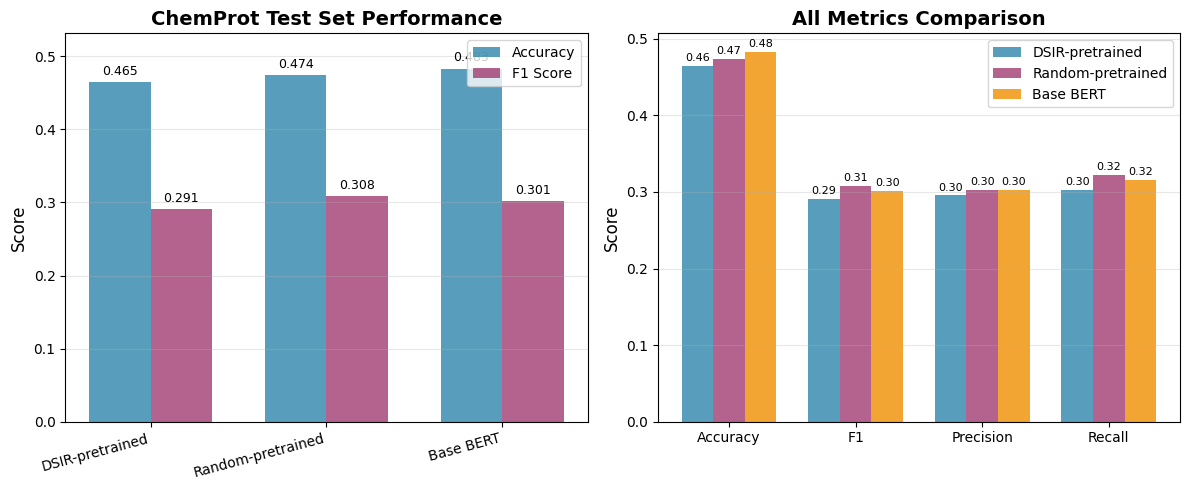


Results visualization saved to: /content/drive/MyDrive/FOUNDATION_ML_FINAL_PROJECT/dsir_chemprot_experiment/final_test_results_comparison.png


In [83]:
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

model_names = list(models_data.keys())
accuracies = [models_data[m]['eval_accuracy'] for m in model_names]
f1_scores = [models_data[m]['eval_f1'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

bars1 = ax1.bar(x - width/2, accuracies, width, label='Accuracy', color='#2E86AB', alpha=0.8)
bars2 = ax1.bar(x + width/2, f1_scores, width, label='F1 Score', color='#A23B72', alpha=0.8)

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('ChemProt Test Set Performance', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(model_names, rotation=15, ha='right')
ax1.legend()
ax1.set_ylim(0, max(max(accuracies), max(f1_scores)) * 1.1)
ax1.grid(axis='y', alpha=0.3)

for bars in [bars1, bars2]:
  for bar in bars:
    height = bar.get_height()
    ax1.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

metrics = ['accuracy', 'f1', 'precision', 'recall']
metric_values = {
    model: [models_data[model][f'eval_{m}'] for m in metrics]
    for model in model_names
}

x2 = np.arange(len(metrics))
width2 = 0.25
colors = ['#2E86AB', '#A23B72', '#F18F01']

for i, (model, values) in enumerate(metric_values.items()):
  offset = width2 * (i - len(model_names)/2 + 0.5)
  bars = ax2.bar(x2 + offset, values, width2, label=model, color=colors[i], alpha=0.8)

  for bar in bars:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 2),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('All Metrics Comparison', fontsize=14, fontweight='bold')
ax2.set_xticks(x2)
ax2.set_xticklabels([m.capitalize() for m in metrics])
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(f'{drive_dir}/final_test_results_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nResults visualization saved to: {drive_dir}/final_test_results_comparison.png")

In [ ]:
print("Ancore code untill here")